### 1. IMPORTS

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. LOAD DATA

In [3]:
df = pd.read_csv('/content/drive/MyDrive/student_survey_cleaned.csv')
df.head()

### 3. FEATURE ENGINEERING

In [5]:
# Group column sets
q1_cols = [col for col in df.columns if col.startswith('Q1-Volunteered')]
q2_cols = [col for col in df.columns if col.startswith('Q2-Participated')]
q3_cols = [col for col in df.columns if col.startswith('Q3-Interested')]
q4_cols = [col for col in df.columns if col.startswith('Q4-Passionate')]
q5_cols = [col for col in df.columns if col.startswith('Q5-Stressed')]

In [6]:
# Rename key columns for simplicity
main_cols = ['Q1-How many events have you Volunteered in ?',
             'Q2-How many events have you Participated in ?',
             'Q3-How many activities are you Interested in ?',
             'Q4-How many activities are you Passionate about ?',
             'Q5-What are your levels of stress ?',
             'Q6-How Satisfied You are with your Student Life ?',
             'Q7-How much effort do you make to interact with others ?',
             'Q8-About How events are you aware about ?']

df = df.rename(columns={
    main_cols[0]: 'num_volunteered',
    main_cols[1]: 'num_participated',
    main_cols[2]: 'num_interested',
    main_cols[3]: 'num_passionate',
    main_cols[4]: 'stress_level',
    main_cols[5]: 'satisfaction',
    main_cols[6]: 'interaction_effort',
    main_cols[7]: 'event_awareness'
})

In [7]:
# Create Summary Columns
df['total_volunteered_areas'] = df[q1_cols].sum(axis=1)
df['total_participated_areas'] = df[q2_cols].sum(axis=1)
df['total_interest_areas'] = df[q3_cols].sum(axis=1)
df['total_passion_areas'] = df[q4_cols].sum(axis=1)
df['total_stressors'] = df[q5_cols].sum(axis=1)

### 4. EDA (Exploratory Data Analysis)

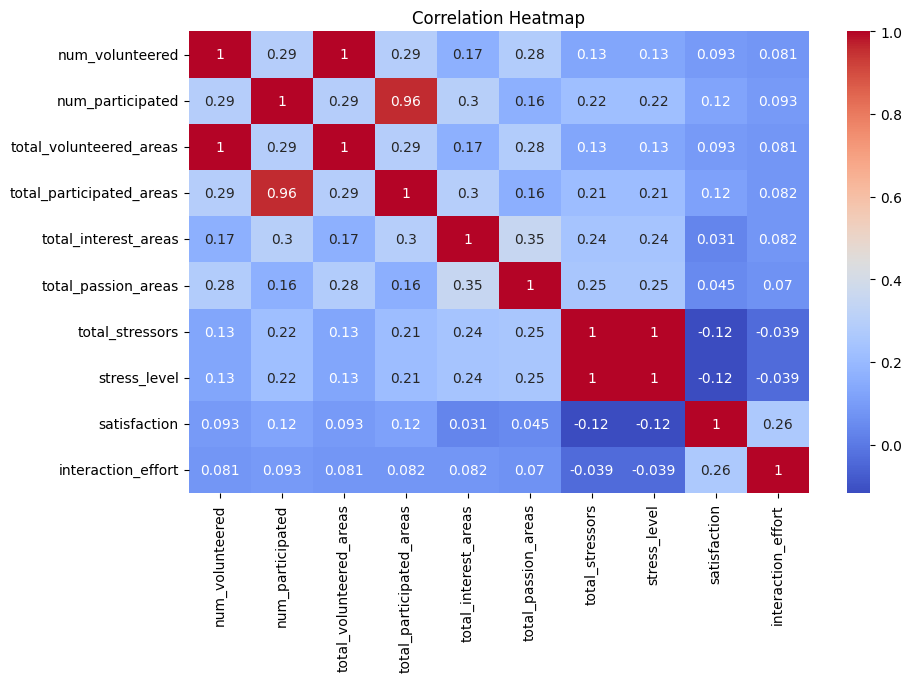

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['num_volunteered', 'num_participated', 'total_volunteered_areas',
                'total_participated_areas', 'total_interest_areas', 'total_passion_areas',
                'total_stressors', 'stress_level', 'satisfaction', 'interaction_effort']]
            .corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

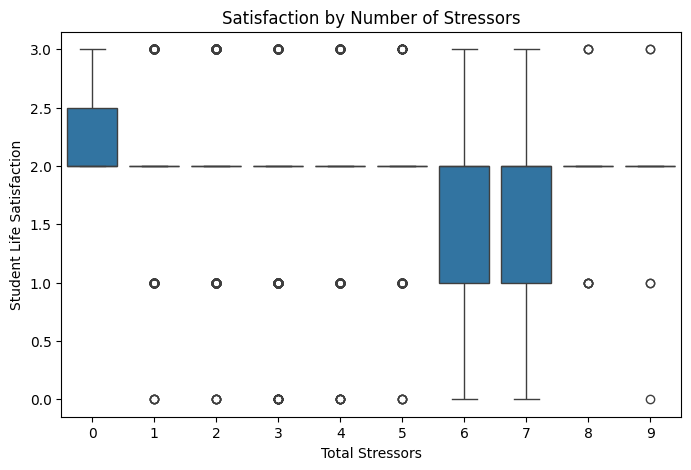

In [12]:
# Satisfaction by number of stressors
plt.figure(figsize=(8, 5))
sns.boxplot(x='total_stressors', y='satisfaction', data=df)
plt.title('Satisfaction by Number of Stressors')
plt.xlabel('Total Stressors')
plt.ylabel('Student Life Satisfaction')
plt.show()

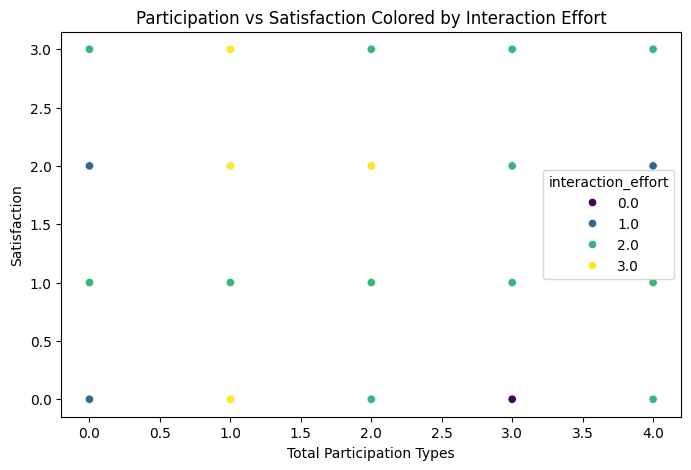

In [13]:
# Participation vs satisfaction
plt.figure(figsize=(8, 5))
sns.scatterplot(x='total_participated_areas', y='satisfaction', hue='interaction_effort', data=df, palette='viridis')
plt.title('Participation vs Satisfaction Colored by Interaction Effort')
plt.xlabel('Total Participation Types')
plt.ylabel('Satisfaction')
plt.show()

### 5. KMEANS CLUSTERING

In [40]:
features_for_clustering = ['total_volunteered_areas', 'total_participated_areas', 'total_stressors', 'satisfaction']
X = df[features_for_clustering]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

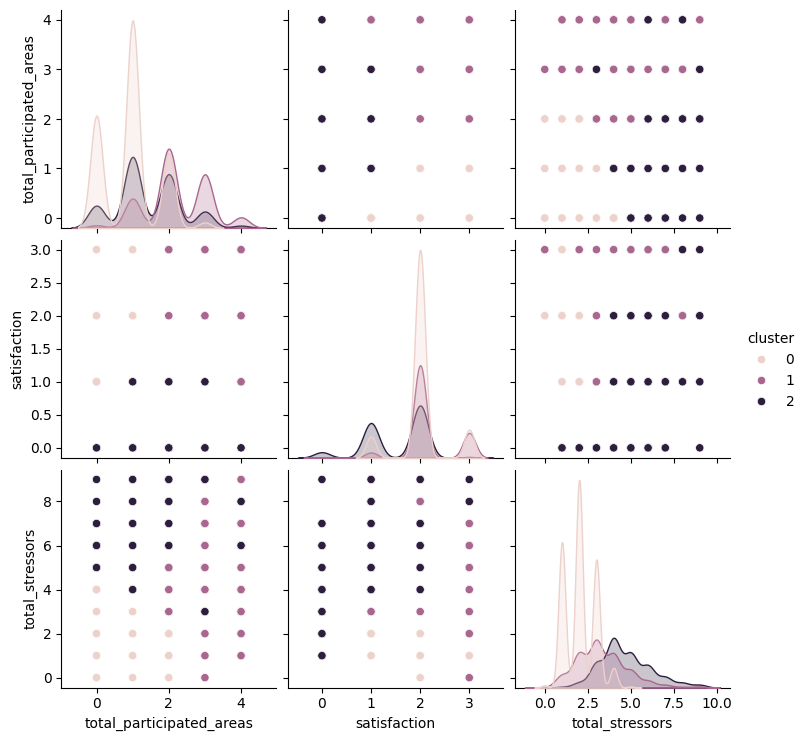

In [41]:
# Visualize clusters
sns.pairplot(df, hue='cluster', vars=['total_participated_areas', 'satisfaction', 'total_stressors'])

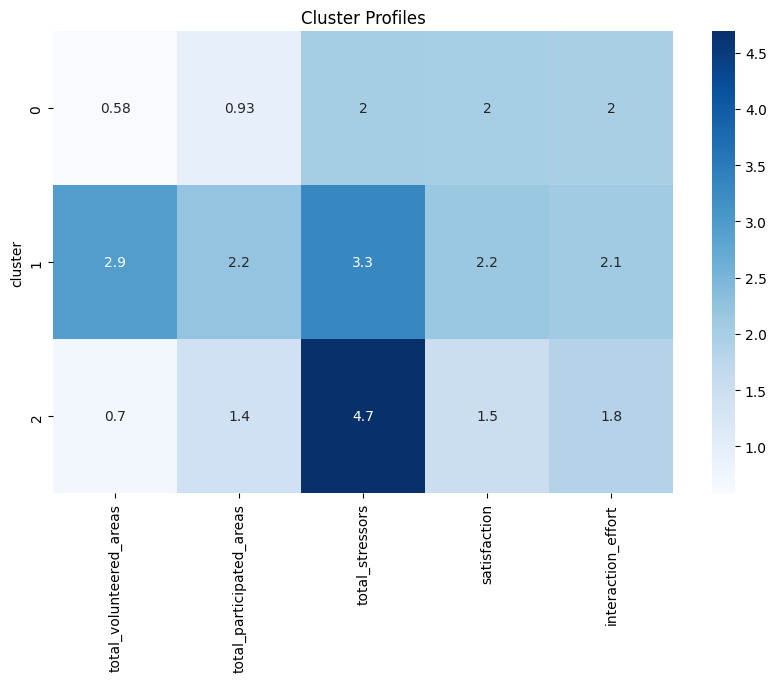

In [42]:
# Cluster profiles
cluster_profile = df.groupby('cluster')[features_for_clustering + ['interaction_effort']].mean()
plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, cmap='Blues')
plt.title("Cluster Profiles")
plt.show()

### 6. RANDOM FOREST REGRESSION

In [43]:
X_rf = df[['num_participated', 'interaction_effort', 'event_awareness', 'total_interest_areas']]
y_rf = df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
print("Random Forest R² Score:", model.score(X_test, y_test))

Random Forest R² Score: -0.02558323620871339


### 7. PCA FOR CLUSTER VISUALIZATION

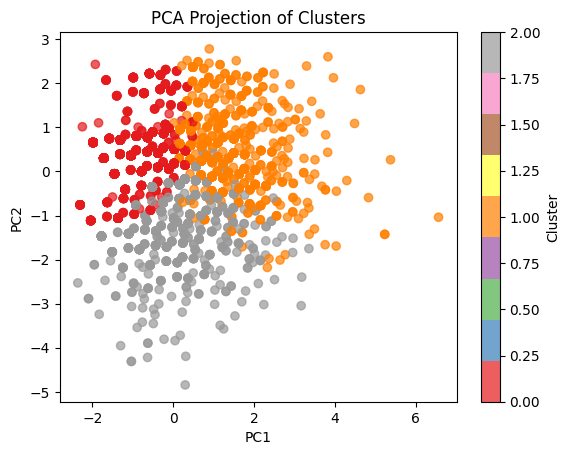

In [44]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='Set1', alpha=0.7)
plt.title('PCA Projection of Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

### 8. CLUSTER INTERPRETATION

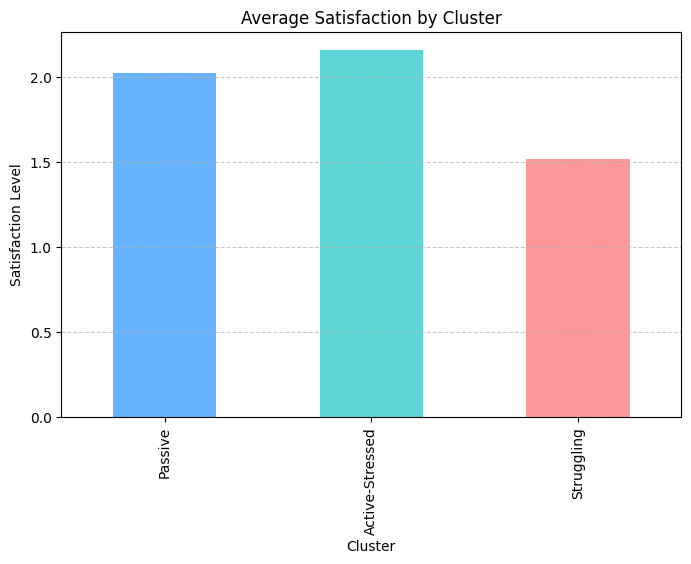

In [45]:
# Satisfaction by cluster
cluster_means = df.groupby('cluster')['satisfaction'].mean()
cluster_means.plot(kind='bar', color=['#66B2FF','#5CD6D6','#FF9999'], figsize=(8,5))
plt.title('Average Satisfaction by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Satisfaction Level')
plt.xticks(ticks=[0,1,2], labels=['Passive', 'Active-Stressed', 'Struggling'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

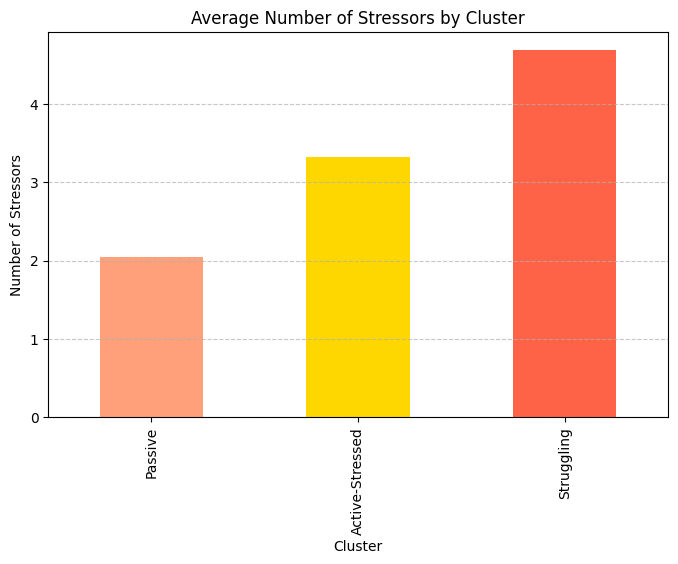

In [46]:
# Stressors by cluster
df.groupby('cluster')['total_stressors'].mean().plot(kind='bar', color=['#FFA07A','#FFD700','#FF6347'], figsize=(8,5))
plt.title('Average Number of Stressors by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Stressors')
plt.xticks(ticks=[0,1,2], labels=['Passive', 'Active-Stressed', 'Struggling'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
# Print profile summary
print("Cluster Profiles Summary:")
print(df.groupby('cluster')[['num_participated', 'satisfaction', 'total_stressors']].mean())

Cluster Profiles Summary:
         num_participated  satisfaction  total_stressors
cluster                                                 
0                1.027656      2.026201         2.042213
1                2.276730      2.157233         3.322013
2                1.515843      1.515843         4.688213


In [50]:
# Get cluster profiles
print(df.groupby('cluster')[['total_volunteered_areas', 'total_participated_areas','total_stressors', 'satisfaction', 'interaction_effort']].mean())

         total_volunteered_areas  total_participated_areas  total_stressors  \
cluster                                                                       
0                       0.582969                  0.933042         2.042213   
1                       2.944654                  2.228931         3.322013   
2                       0.697085                  1.429658         4.688213   

         satisfaction  interaction_effort  
cluster                                    
0            2.026201            1.966276  
1            2.157233            2.077215  
2            1.515843            1.843511  


## **Student Engagement & Satisfaction Analysis Report**

### 1. Introduction

This report explores data from a student survey aimed at understanding:
- Involvement in volunteering and events
- Areas of interest and passion
- Stress levels
- Satisfaction with student life
- Interaction effort

We used clustering, correlation analysis, and predictive modelling to uncover patterns and identify groups of students with similar experiences.

### 2. Methodology

#### Data Overview
- Dataset: `student_survey_cleaned.csv`
- Key metrics derived:
  - Total areas volunteered in
  - Total types of participation
  - Total stressors endorsed
  - Satisfaction level
  - Interaction effort

#### Techniques Used
1. KMeans Clustering – To group students into behavioral segments
2. Random Forest Regression – To predict satisfaction
3. PCA Visualization – To better understand cluster separation
4. Correlation Heatmap & Boxplots – To explore relationships between variables

### 3. Key Findings

| Finding | Description |
|--------|-------------|
| 📈 Participation vs Satisfaction | More involvement generally leads to higher satisfaction |
| ⚠️ Stress Impact | Higher number of stressors is linked to lower satisfaction |
| 🧠 Interaction Matters | Students who put in more effort to interact are more satisfied |
| 📉 Prediction Limitations | A random forest model only explained negative variance (R² = -0.026), suggesting satisfaction is complex and not easily predicted by behavior alone |


### 4. Student Clusters (Behavioral Segments)

We identified 3 distinct student types using KMeans clustering:

| Cluster | Name | Volunteering | Participation | Stress | Satisfaction | Description |
|--------|------|--------------|----------------|--------|---------------|-------------|
| 0 | Passive Participants | Low | Low | Medium | Medium | Not very involved, but managing okay |
| 1 | Active but Stressed | High | High | Very High | Slightly above average | Highly engaged, but under pressure |
| 2 | Struggling Engagers | Low-Moderate | Moderate | Very High | Lowest | Trying to engage but overwhelmed |


### 5. Correlation & Visualization Insights

#### Strong Relationships Found
- Positive correlation between:
  - Participation and satisfaction
  - Interaction effort and satisfaction
- Negative correlation between:
  - Number of stressors and satisfaction

#### Visual Highlights
- Satisfaction decreases as stress increases (boxplot)
- Higher participation correlates with higher satisfaction, especially when combined with high interaction effort (scatterplot)

### 6. Predictive Modeling Attempt

A Random Forest Regressor was trained to predict satisfaction based on:
- Number of events participated in
- Event awareness
- Interaction effort
- Total interest areas

#### Result:
- R² Score: -0.026
- This suggests the model did worse than guessing the mean, indicating that:
  - Satisfaction depends on factors not captured in the dataset
  - Behavioral metrics alone are insufficient to predict satisfaction accurately

### 7. Actionable Recommendations

| Group | Insight | Recommendation |
|-------|---------|----------------|
| All Clusters | Stress negatively affects satisfaction | Offer regular wellness workshops and mental health support |
| Cluster 0 – Passive | Low involvement, moderate satisfaction | Promote event awareness, create casual interest-based clubs, encourage peer connections |
| Cluster 1 – Active-Stressed | Highly involved but stressed | Recognize contributions, teach time management, avoid overloading with events |
| Cluster 2 – Struggling | Trying hard but dissatisfied and stressed | Provide counseling, reduce workload expectations, build inclusive communities |

### 8. Conclusion

This study reveals that student satisfaction is influenced by a mix of behavioral, emotional, and situational factors. While active students tend to be happier, many face high stress. Some students are trying to get involved but feel overwhelmed.

To improve student experience:
- Balance engagement with well-being
- Tailor support to student types
- Create inclusive, low-pressure opportunities for connection